<a href="https://colab.research.google.com/github/thiagodsd/science-avec-des/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import warnings
import pickle
import gc
import os
import math
import pprint

from google.colab import drive, files

In [0]:
import numpy  as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

In [0]:
# json = files.upload()

In [0]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c nyc-taxi-trip-duration
# !unzip '*.zip'

In [21]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])

train:  (1458644, 11)
test:   (625134, 9)


- - -

Working on a sample of geographic coordinates

In [0]:
sample = df_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].sample(12345)

# Standard Deviation

In [0]:
def out_std(data, n_std=3.0, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    mean, std    = data.mean(), data.std()
    cutoff       = std * n_std
    lower, upper = mean - cutoff, mean + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

In [43]:
# version 1
out_mask_std = out_std(sample['dropoff_latitude'], n_std=3.0)
display( np.unique(out_mask_std, return_counts=True) )

(array([False,  True]), array([12079,   266]))

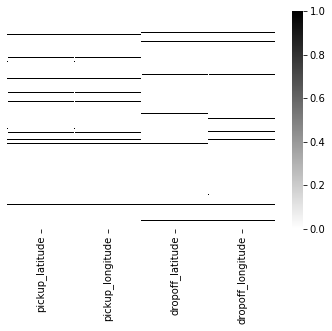

In [44]:
# version 2
feature_mask = sample.dtypes[~(sample.dtypes.isin([ np.dtype('object'),  np.dtype('<M8[ns]')]))].index
out_mask_std = sample[feature_mask].apply(out_std, n_std=3.0)

f, ((ax1)) = plt.subplots(ncols=1, nrows=1)
sns.heatmap(out_mask_std, cmap='binary', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.axes.get_yaxis().set_visible(False)

# Interquartile Range Method

> A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

In [0]:
def out_iqr(data, k=1.5, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    q25, q75     = np.percentile(data, 25), np.percentile(data, 75)
    iqr          = q75 - q25
    cutoff       = iqr * k
    lower, upper = q25 - cutoff, q75 + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

In [46]:
# version 1
out_mask_iqr = out_iqr(sample['dropoff_latitude'], k=1.5)
display( np.unique(out_mask_iqr, return_counts=True) )

(array([False,  True]), array([11755,   590]))

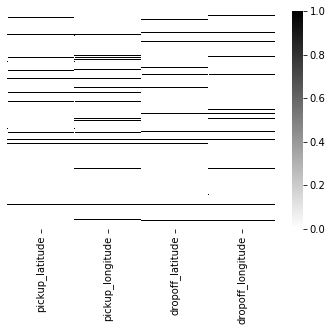

In [47]:
# version 2
feature_mask = sample.dtypes[~(sample.dtypes.isin([ np.dtype('object'),  np.dtype('<M8[ns]')]))].index
out_mask_iqr = sample[feature_mask].apply(out_iqr, k=1.5)

f, ((ax1)) = plt.subplots(ncols=1, nrows=1)
sns.heatmap(out_mask_iqr, cmap='binary', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.axes.get_yaxis().set_visible(False)

# Isolation Forest

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


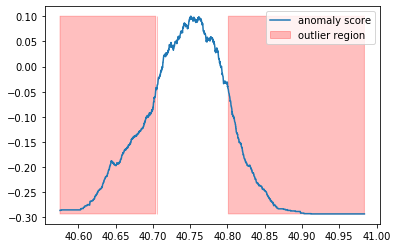

In [51]:
# univariate

from sklearn.ensemble import IsolationForest

out_if = IsolationForest(n_estimators=100)
out_if.fit(sample['dropoff_latitude'].values.reshape(-1, 1))

xx            = np.linspace(sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max(), int(sample.shape[0]/5.0)).reshape(-1, 1)
anomaly_score = out_if.decision_function(xx)
out_bounds    = out_if.predict(xx)

plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score),  np.max(anomaly_score), where=(out_bounds==-1), alpha=.25, color='r', label='outlier region')
plt.legend();

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


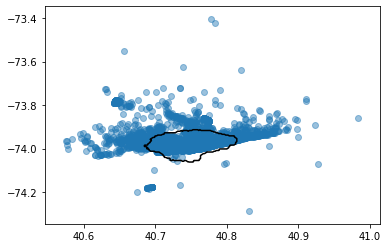

In [52]:
# multivariate

from sklearn.ensemble import IsolationForest

out_if = IsolationForest()
out_if.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

xx_bounds = [sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max()]
yy_bounds = [sample['dropoff_longitude'].min(), sample['dropoff_longitude'].max()]

xx, yy = np.meshgrid(np.linspace(min(xx_bounds), max(xx_bounds), 250),
                     np.linspace(min(yy_bounds), max(yy_bounds), 250))
zz     = out_if.predict(np.c_[xx.ravel(), yy.ravel()])
zz     = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

# Elliptic Envelope

> Outlier detection from covariance estimation may break or not perform well in high-dimensional settings. In particular, one will always take care to work with n_samples > n_features ** 2.

([ref](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope))

In [53]:
from sklearn.covariance import EllipticEnvelope

out_elp = EllipticEnvelope()
out_elp.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

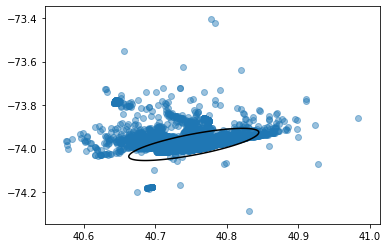

In [54]:
xx_bounds = [sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max()]
yy_bounds = [sample['dropoff_longitude'].min(), sample['dropoff_longitude'].max()]

xx, yy = np.meshgrid(np.linspace(min(xx_bounds), max(xx_bounds), 250),
                     np.linspace(min(yy_bounds), max(yy_bounds), 250))
zz     = out_elp.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz     = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

# DBSCAN

In [82]:
from sklearn.preprocessing  import StandardScaler
from sklearn.cluster        import DBSCAN

X      = StandardScaler().fit_transform(sample[['dropoff_latitude', 'dropoff_longitude']].values)
out_db = DBSCAN(eps=0.45, min_samples=100 ).fit(X)
labels = out_db.labels_

np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2]), array([  540, 11547,   156,   102]))

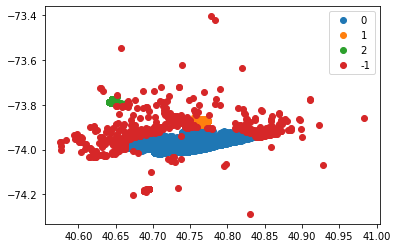

In [83]:
unique_labels = set(labels)

for label in unique_labels:
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(sample['dropoff_latitude'][sample_mask], sample['dropoff_longitude'][sample_mask], 'o', label=label);
plt.legend();

# Local Outlier Factor

>  The advantage of sklearn.neighbors.LocalOutlierFactor over the other estimators is shown for the third data set, where the two modes have different densities. This advantage is explained by the local aspect of LOF, meaning that it only compares the score of abnormality of one sample with the scores of its neighbors.

In [86]:
from sklearn.neighbors import LocalOutlierFactor

out_lof = LocalOutlierFactor(n_neighbors=100, novelty=True)
out_lof.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=100, novelty=True, p=2)

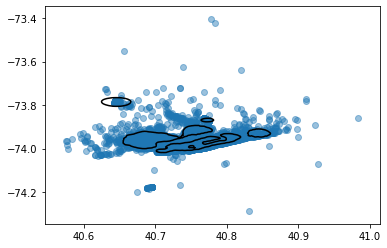

In [87]:
xx_bounds = [sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max()]
yy_bounds = [sample['dropoff_longitude'].min(), sample['dropoff_longitude'].max()]

xx, yy = np.meshgrid(np.linspace(min(xx_bounds), max(xx_bounds), 250),
                     np.linspace(min(yy_bounds), max(yy_bounds), 250))
zz     = out_lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz     = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');